In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

## Preprocessing Data

In [3]:
random.seed(42)

base_dir = '/kaggle/input/tuberculosis-tb-chest-xray-dataset/TB_Chest_Radiography_Database'
tuber_files = list(os.walk(base_dir))[1][2]
normal_files = list(os.walk(base_dir))[2][2]
tuber_paths = [os.path.join(base_dir, 'Tuberculosis', fname) for fname in tuber_files]
normal_paths = [os.path.join(base_dir, 'Normal', fname) for fname in normal_files]
normal_paths = random.sample(normal_paths, len(tuber_paths))
paths = tuber_paths + normal_paths

In [4]:
df = pd.DataFrame({'path': paths})
df['label'] = df['path'].map(lambda x: x.split('/')[-2])

label_dict = {'Tuberculosis': 1, 'Normal': 0}
df['label'] = df['label'].map(label_dict)
df.head()

,path,label
0,/kaggle/input/tuberculosis-tb-chest-xray-datas...,1
1,/kaggle/input/tuberculosis-tb-chest-xray-datas...,1
2,/kaggle/input/tuberculosis-tb-chest-xray-datas...,1
3,/kaggle/input/tuberculosis-tb-chest-xray-datas...,1
4,/kaggle/input/tuberculosis-tb-chest-xray-datas...,1


In [5]:
df['label'].value_counts()

label
1    700
0    700
Name: count, dtype: int64

In [6]:
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)

train_df, val_df = train_test_split(train_val_df, test_size=0.1765, stratify=train_val_df['label'], random_state=42)

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406])
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225])

rotation_layer = tf.keras.layers.RandomRotation(factor=0.03, fill_mode='nearest')

def decode_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    image = (image - IMAGENET_MEAN) / IMAGENET_STD
    return image, label
    
def augment(image, label):
    if tf.random.uniform(()) < 0.2:
        image = tf.image.flip_left_right(image)

    if tf.random.uniform(()) < 0.2:
        image = rotation_layer(image, training=True)

    return image, label

def prepare_dataset(df, augment_data=False):
    filepaths = df['path'].values
    labels = df['label']

    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    ds = ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment_data:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.shuffle(buffer_size=1000)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(train_df, augment_data=True)
val_dataset  = prepare_dataset(val_df)
test_dataset = prepare_dataset(test_df)

I0000 00:00:1749939226.995682      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Raw X-ray Classification

In [ ]:
NUM_CLASSES = 2

def build_model():
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    
    base_model.trainable = False

    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [29]:
model = build_model()

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,375,304 (92.98 MB)

 Trainable params: 262,530 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 525,062 (2.00 MB)

In [8]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[
        EarlyStopping(
            patience=3, 
            restore_best_weights=True
        ),
        ModelCheckpoint(
            "tuberculosis_detectioin.keras", 
            save_best_only=True
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            verbose=1,
            min_lr=1e-7
        )
    ]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100


I0000 00:00:1749932964.242553      92 service.cc:148] XLA service 0x7cc830002110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749932964.243181      92 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749932965.709659      92 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/62 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5719 - loss: 0.7902

I0000 00:00:1749932969.130314      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 210ms/step - accuracy: 0.5588 - loss: 0.7649 - val_accuracy: 0.7109 - val_loss: 0.6089 - learning_rate: 1.0000e-04
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.6585 - loss: 0.6288 - val_accuracy: 0.8009 - val_loss: 0.5447 - learning_rate: 1.0000e-04
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.7291 - loss: 0.5689 - val_accuracy: 0.8009 - val_loss: 0.5066 - learning_rate: 1.0000e-04
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.7960 - loss: 0.4769 - val_accuracy: 0.8341 - val_loss: 0.4619 - learning_rate: 1.0000e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.8208 - loss: 0.4428 - val_accuracy: 0.8578 - val_loss: 0.4258 - learning_rate: 1.0000e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.8467 - loss: 0.4034 - val_accuracy: 0.8578 - val_loss: 0.3963 - learning_rate: 1.0000e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.8440 - l

In [8]:
model = load_model('/kaggle/input/xray_tuberculosis_detection/tensorflow2/default/1/tuberculosis_detectioin.keras')

In [10]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.9677 - loss: 0.1184
Test Loss: 0.1190
Test Accuracy: 0.9714


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
              precision    recall  f1-score   support

           0     0.9626    0.9810    0.9717       105
           1     0.9806    0.9619    0.9712       105

    accuracy                         0.9714       210
   macro avg     0.9716    0.9714    0.9714       210
weighted avg     0.9716    0.9714    0.9714       210




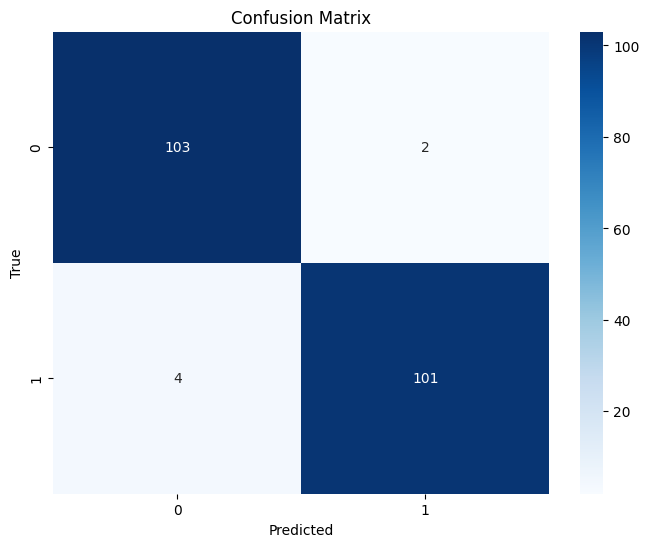

In [13]:
y_pred_raw = model.predict(test_dataset)
y_pred = np.argmax(y_pred_raw, axis=1)

y_test = test_df['label'].values
cm = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, digits=4))
print()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

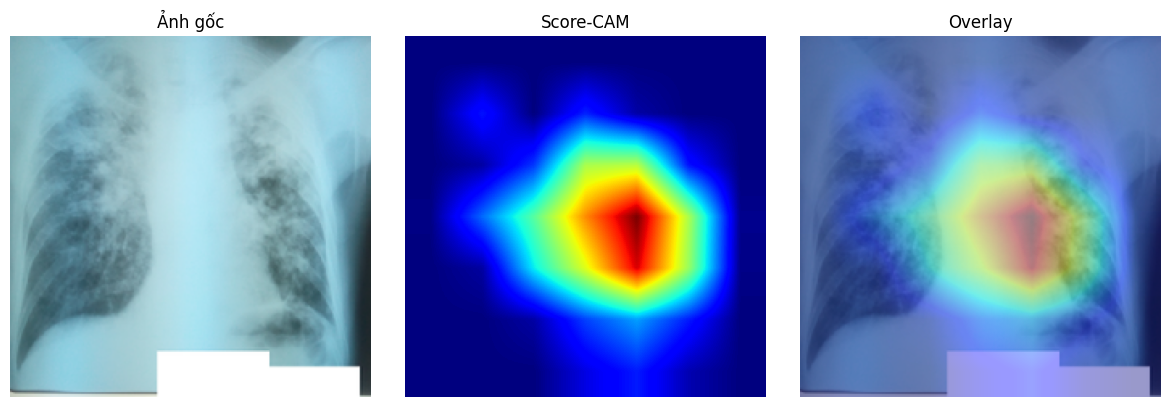

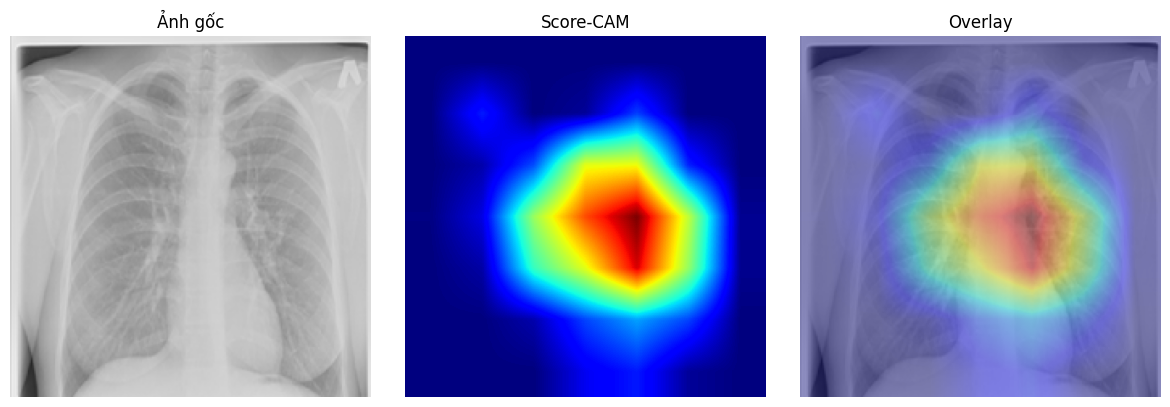

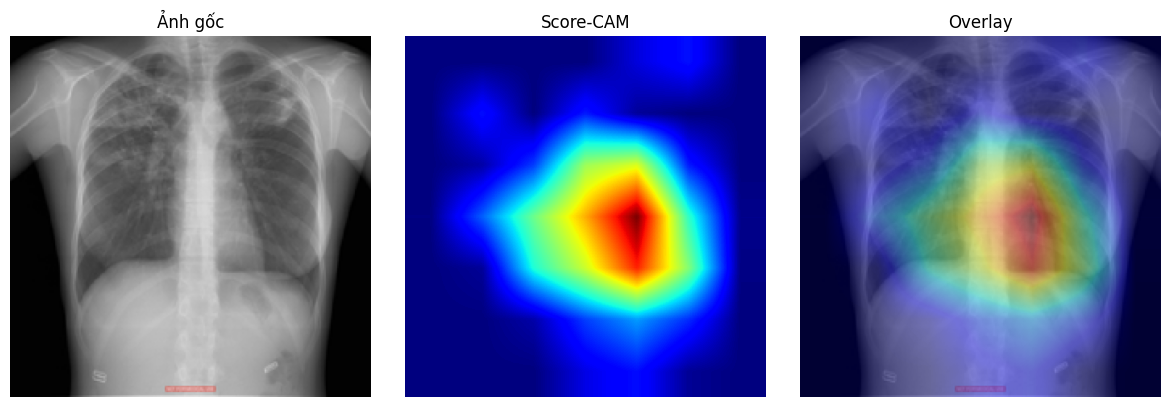

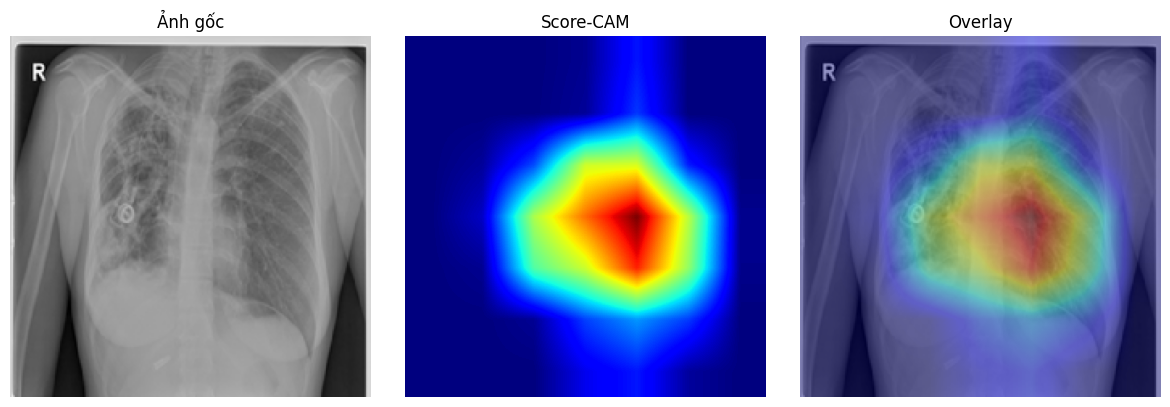

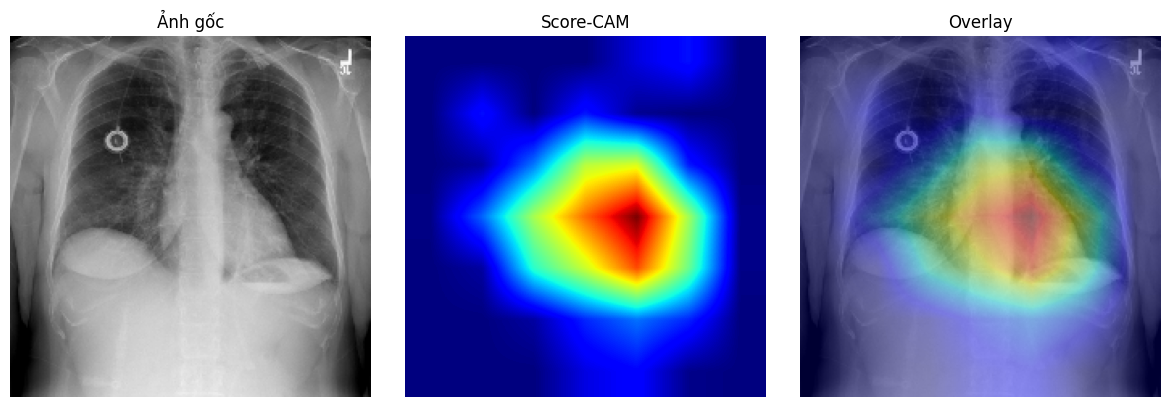

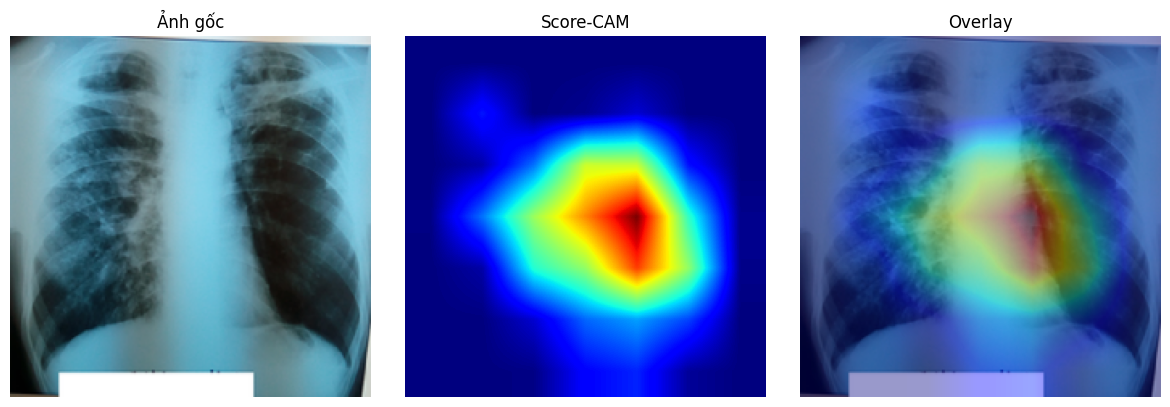

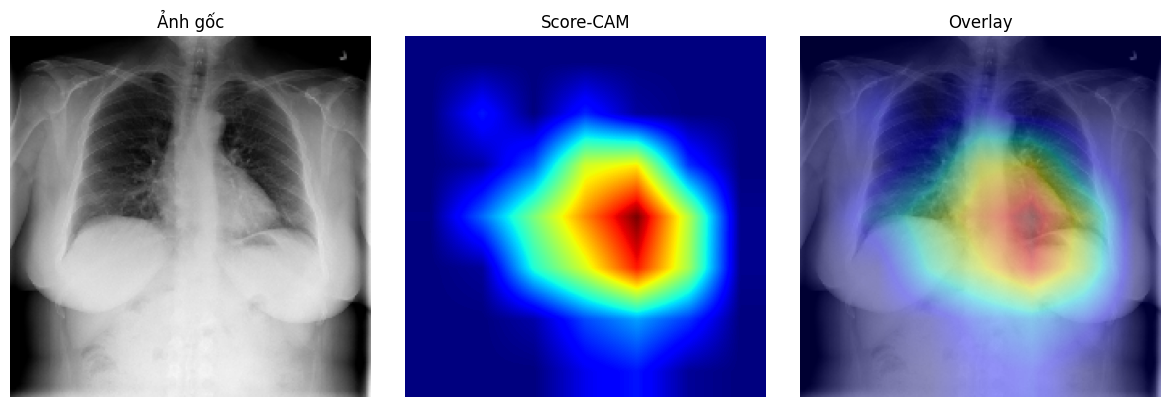

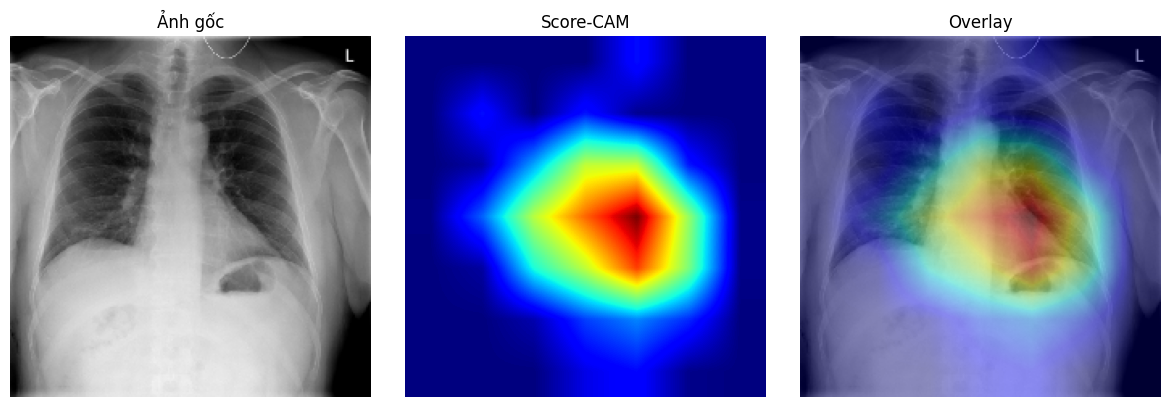

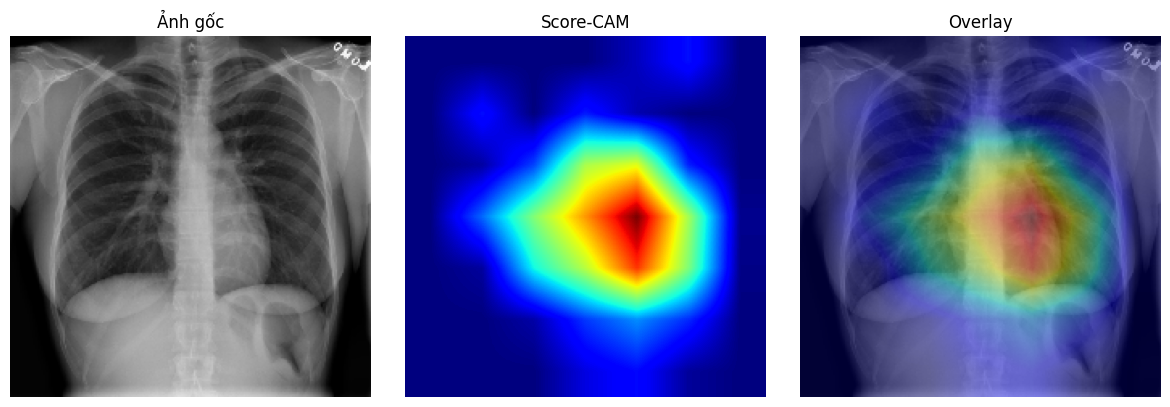

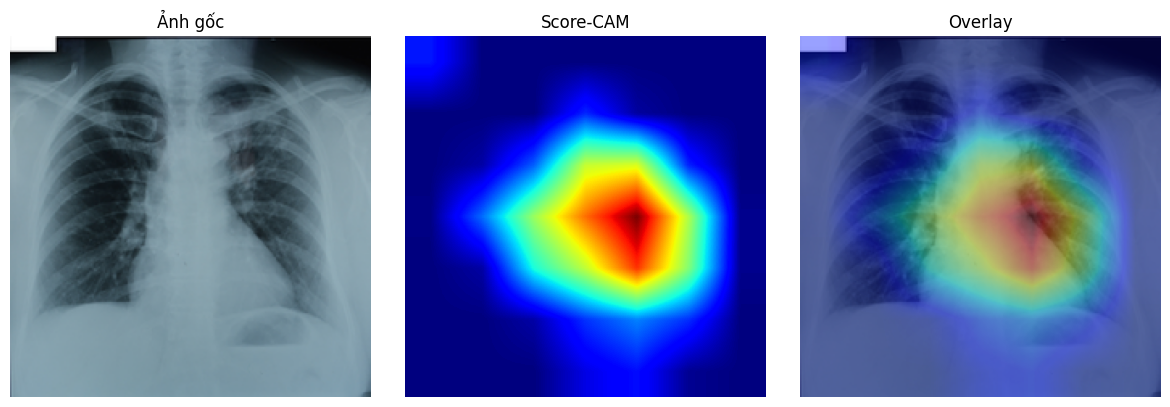

In [48]:
def score_cam(model, img_array):
    resnet_layer = model.get_layer('resnet50')
    feature_maps = resnet_layer(img_array)
    feature_maps = feature_maps.numpy()[0]
    
    h, w = img_array.shape[1], img_array.shape[2]
    scores = []
    
    for i in range(min(50, feature_maps.shape[-1])):
        fmap = feature_maps[:, :, i]
        if fmap.max() > fmap.min():
            fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min())
        
        mask = cv2.resize(fmap.astype(np.float32), (w, h))
        mask = np.expand_dims(mask, axis=-1)
        
        masked_img = img_array[0] * mask
        masked_img = np.expand_dims(masked_img, 0)
        
        pred = model.predict(masked_img, verbose=0)[0]
        score = np.max(pred)
        scores.append(score)
    
    scores = np.array(scores)
    cam = np.zeros((h, w))
    
    for i, score in enumerate(scores):
        fmap = feature_maps[:, :, i]
        if fmap.max() > fmap.min():
            fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min())
        resized_fmap = cv2.resize(fmap.astype(np.float32), (w, h))
        cam += score * resized_fmap
    
    if cam.max() > cam.min():
        cam = (cam - cam.min()) / (cam.max() - cam.min())
    
    return cam

def visualize_score_cam(img_path, model):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, 0)
    
    cam = score_cam(model, img_array)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Ảnh gốc')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title('Score-CAM')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(cam, cmap='jet', alpha=0.4)
    plt.title('Overlay')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


img_path_tests = test_df.head(10)['path'].to_list()
for img_path in img_path_tests:
    visualize_score_cam(img_path, model)